# Dependencies

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import matplotlib.colors as mcolors
import numpy as np
import itertools
import requests
import os
import shutil
import time
import joblib
import seaborn as sns
import warnings
from sklearn.decomposition import PCA
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.under_sampling import TomekLinks, EditedNearestNeighbours
from imblearn.over_sampling import SMOTE
from sklearn.datasets import make_classification
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
%load_ext google.colab.data_table
warnings.filterwarnings('ignore')

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


# Eda

In [ ]:
# load data
df = pd.read_excel('2_senate_results.xlsx')
columns_to_select = ['state', 'year', 'incumbent', '1m_total_pop', '3m_total_pop', '12m_total_pop', 'education_ratio', 'committee_count', 'party', 'unemployment', 'age', 'vote_share']
model_df = df[columns_to_select]
columns_to_select_money = ['vote_share', '1m_total', '3m_total', '12m_amount', 'party']
money_df = df[columns_to_select_money]
money_df = money_df.dropna(subset=columns_to_select_money)

# take log
columns_to_transform = ['1m_total', '3m_total', '12m_amount']
money_df[columns_to_transform] = np.log10(money_df[columns_to_transform])

# fill in infinitely small values
money_df.loc[money_df['3m_total'] < .000001, '3m_total'] = 0
money_df.loc[money_df['12m_amount'] < .000001, '12m_amount'] = 0

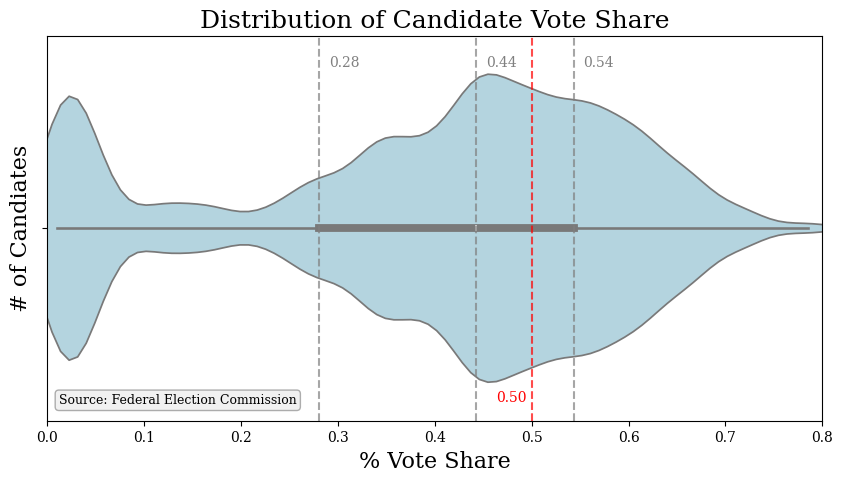

In [ ]:
# create a horizontal violin plot
plt.rcParams['font.family'] = 'Serif'
fig, ax = plt.subplots(figsize=(10, 5))
sns.violinplot(x=model_df['vote_share'], orient='h',palette=['lightblue'], bw=0.12)

# set labels and legend
title = 'Distribution of Candidate Vote Share'
plt.title(title, fontsize=18)
plt.xlabel('% Vote Share', fontsize=16)
plt.ylabel('# of Candiates', fontsize=16)
ax.set_xlim(left=0, right = .80001)

# add quantiles
quantiles = model_df['vote_share'].quantile([0.25, 0.5, 0.75]).values
for q in quantiles:
    ax.axvline(q, linestyle='--', color='grey', alpha=0.7)
    ax.text(q + .01, -.42, f'{round(q, 2)}', color='grey')#, ha='left', va='bottom')

# add red line
ax.axvline(.5, linestyle='--', color='red', alpha=0.7)
ax.text(.463, .45, '0.50', color='red')#, ha='left', va='bottom')

# source
props = dict(boxstyle='round', facecolor='lightgrey', alpha=0.3)
textstr = 'Source: Federal Election Commission'
ax.text(0.015, 0.044, textstr, transform=ax.transAxes, fontsize=9, bbox=props)

plt.savefig(f'{title}.png')
plt.show()

In [ ]:
# find mean to compare with median
vote_share = model_df['vote_share']
mean = model_df['vote_share'].mean()
print(mean)
sd = model_df['vote_share'].std()
print(sd)

0.3918136363636364
0.204973919257445


## Incumbency

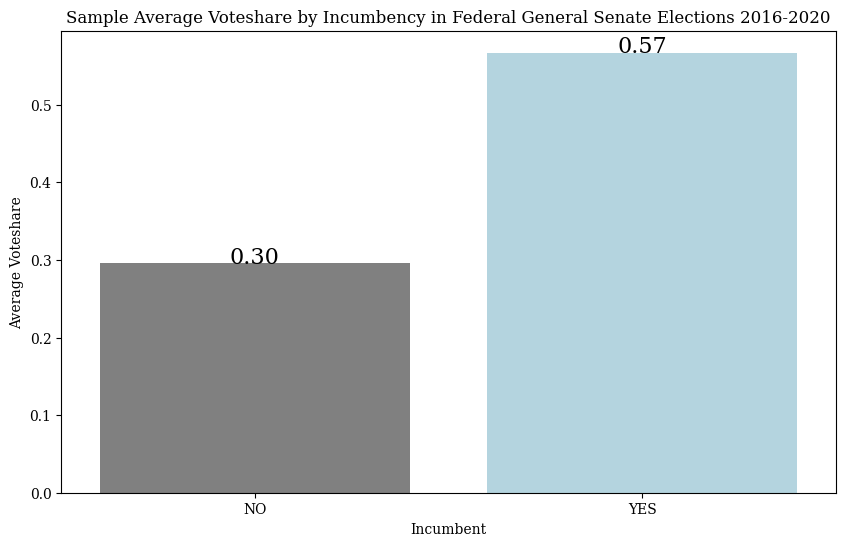

In [ ]:
# plot the bar chart with specified colors
average_voteshare = model_df.groupby('incumbent')['vote_share'].mean().reset_index()
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='incumbent', y='vote_share', data=average_voteshare, palette=['grey', 'lightblue'])
title = 'Sample Average Voteshare by Incumbency in Federal General Senate Elections 2016-2020'
plt.title(f'{title}')
plt.xlabel('Incumbent')
plt.ylabel('Average Voteshare')

# add actual average voteshare values to the graph
for index, row in average_voteshare.iterrows():
    ax.text(index, row['vote_share'], '{:.2f}'.format(row['vote_share']), color='black', ha="center", fontsize=16)
ax.set_xticklabels(['NO', 'YES'])
plt.savefig(f'{title}.png')
plt.show()

## Education ratio state rankings

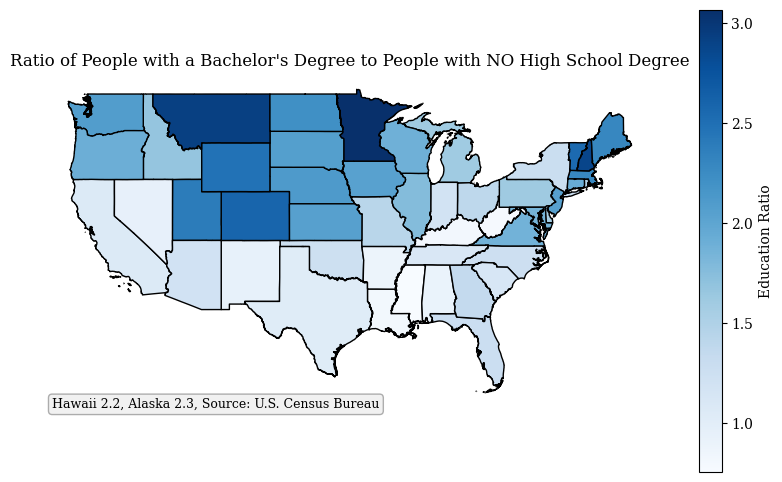

In [ ]:
# create education df
state_education = model_df.groupby('state', as_index=False)['education_ratio'].mean()
state_education.columns = ['state', 'avg_education_ratio']
state_education.rename(columns={'state': 'STUSPS'}, inplace=True)
state_education.head(3)

# load in the geo state data
us_states = gpd.read_file('cb_2018_us_state_500k.shp')
continental_us_states = us_states.cx[-125:-65, 25:50]

# join the geo state data to the education data
continental_us_states = continental_us_states.merge(state_education, on='STUSPS',how='left')

# plot the sob
fig, ax = plt.subplots(figsize=(10, 6))
cmap = plt.cm.get_cmap('Blues')
continental_us_states.plot(ax=ax, column='avg_education_ratio', cmap=cmap, edgecolor='black', legend=True, legend_kwds={'label': 'Education Ratio'})

# remove tick labels
ax.set_xticks([])
ax.set_yticks([])

# remove axis lines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# text box
props = dict(boxstyle='round', facecolor='lightgrey', alpha=0.3)
textstr = 'Hawaii 2.2, Alaska 2.3, Source: U.S. Census Bureau'
ax.text(0.02, 0.00, textstr, transform=ax.transAxes, fontsize=9, bbox=props)

# lets take a look
title = "Ratio of People with a Bachelor's Degree to People with NO High School Degree"
plt.title(f'{title}')
plt.savefig(f'{title}.png')
plt.show()

## Party Vote-Share by State (Binary)

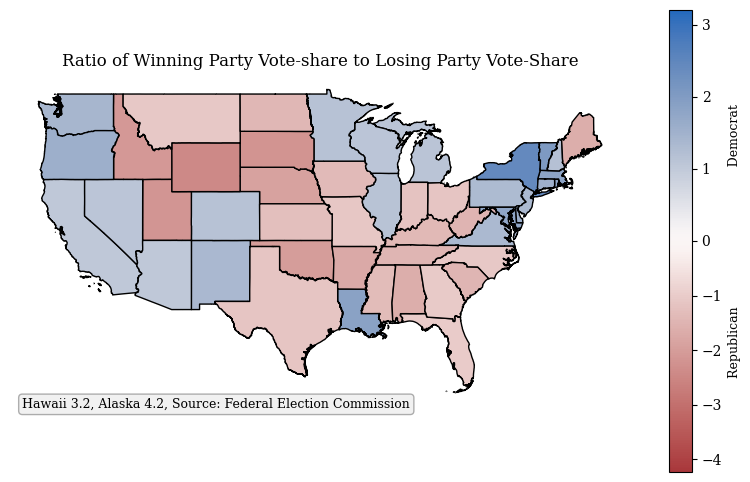

In [ ]:
import matplotlib.colors as mcolors
# create party df
party_df = model_df.copy()
party_df = party_df[party_df['party'] != 'O']
party_df = party_df.groupby(['state', 'party'])['vote_share'].mean()
party_df = party_df.reset_index()
party_df.columns = ['state', 'party', 'avg_vote_share']

# pivot to study the party differences
pivot_df = party_df.pivot(index='state', columns='party', values='avg_vote_share')
democrat_mean = pivot_df['D'].mean()
republican_mean = pivot_df['R'].mean()

# impute NAs with the party average vote_share
pivot_df['D'] = pivot_df['D'].fillna(democrat_mean)
pivot_df['R'] = pivot_df['R'].fillna(republican_mean)

# party ratio for the grapgh. High numbers are D, low are R.
pivot_df['democrat_ratio'] = pivot_df['D'] / pivot_df['R']
pivot_df['republican_ratio'] = pivot_df['R'] / pivot_df['D']
pivot_df['democrat_to_republican_ratio'] = pivot_df[['democrat_ratio', 'republican_ratio']].max(axis=1)
pivot_df.loc[pivot_df['R'] > pivot_df['D'], 'democrat_to_republican_ratio'] *= -1

# get 'state' as a column again
party_df = pivot_df.reset_index()
party_df.rename(columns={'state': 'STUSPS'}, inplace=True)

# load in the geo state data
us_states = gpd.read_file('cb_2018_us_state_500k.shp')
continental_us_states = us_states.cx[-125:-65, 25:50]

# join the geo state data to the education data
continental_us_states = continental_us_states.merge(party_df, on='STUSPS',how='left')

# plot the sob
fig, ax = plt.subplots(figsize=(10, 6))
cmap = plt.cm.get_cmap('vlag_r')

# set color map
center_value = 0
data = pivot_df['democrat_to_republican_ratio']
norm = mcolors.TwoSlopeNorm(vmin=data.min(), vcenter=center_value, vmax=data.max())

# plot grapgh
continental_us_states.plot(ax=ax, column='democrat_to_republican_ratio', cmap=cmap, norm=norm, edgecolor='black', legend=True)
cbar = ax.get_figure().get_axes()[1]
cbar.set_ylabel('Republican                                   Democrat',fontsize=9)

# remove tick labels
ax.set_xticks([])
ax.set_yticks([])

# remove axis lines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# text box
props = dict(boxstyle='round', facecolor='lightgrey', alpha=0.3)
textstr = 'Hawaii 3.2, Alaska 4.2, Source: Federal Election Commission'
ax.text(0.02, 0.00, textstr, transform=ax.transAxes, fontsize=9, bbox=props)

# plot
title = 'Ratio of Winning Party Vote-share to Losing Party Vote-Share'
plt.title(f'{title}')
plt.savefig(f'{title}.png')
plt.show()

## Vote Share by Party

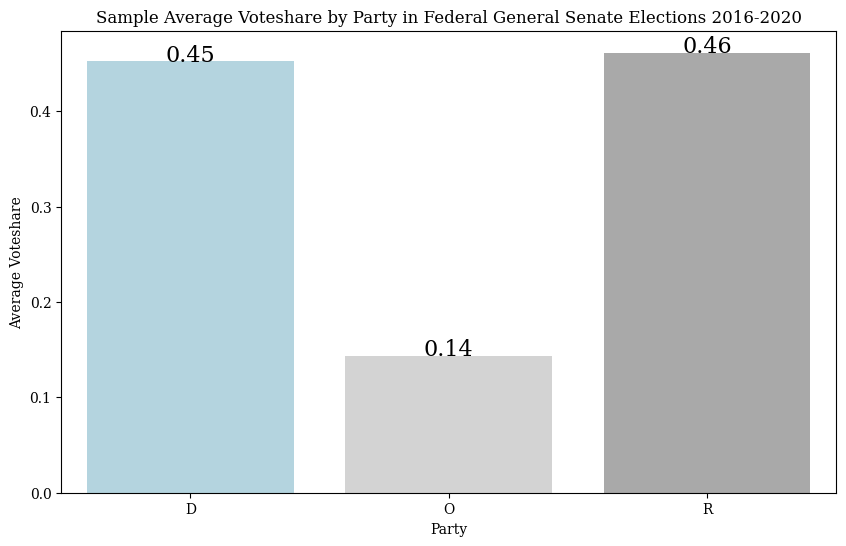

In [ ]:
# prepare data
average_voteshare = model_df.groupby('party')['vote_share'].mean().reset_index()

# plot the bar chart with specified colors
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='party', y='vote_share', data=average_voteshare, palette=['lightblue','lightgray', 'darkgray'])
title = 'Sample Average Voteshare by Party in Federal General Senate Elections 2016-2020'
plt.title(f'{title}')
plt.xlabel('Party')
plt.ylabel('Average Voteshare')

# add actual average voteshare values to the graph
for index, row in average_voteshare.iterrows():
    ax.text(index, row['vote_share'], '{:.2f}'.format(row['vote_share']), color='black', ha="center", fontsize=16)
ax.set_xticklabels(['D', 'O','R' ])
plt.savefig(f'{title}.png')
plt.show()

## Amount Raised and Vote Share

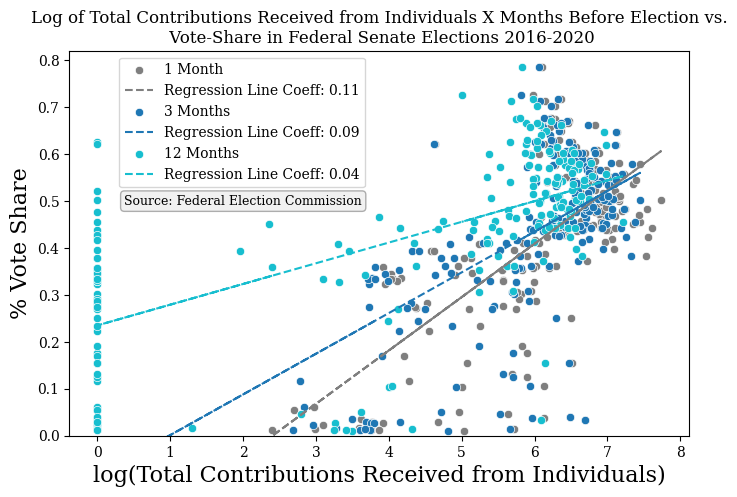

In [ ]:
df = money_df.copy()
from scipy.stats import linregress
# Create subplots
fig, ax = plt.subplots(figsize=(8, 5))

df.rename(columns={'1m_total': '1 Month', '3m_total': '3 Months', '12m_amount': '12 Months'}, inplace=True)
columns_to_plot = ['1 Month', '3 Months', '12 Months']

custom_colors = sns.color_palette()
custom_palette = [custom_colors[7], custom_colors[0], custom_colors[9]]
#custom_palette = sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True, 3)

# Plot each column
for i, column in enumerate(df[columns_to_plot].columns):
    sns.scatterplot(x=column, y='vote_share', data=df, ax=ax, label=column, color=custom_palette[i])

    # Calculate regression line
    slope, intercept, r_value, p_value, std_err = linregress(df[column], df['vote_share'])
    line = slope * df[column] + intercept

    # Plot regression line
    ax.plot(df[column], line, label=f'Regression Line Coeff: {slope:.2f}', linestyle='--', color=custom_palette[i])



# Set labels and legend
title = 'Log of Total Contributions Received from Individuals X Months Before Election vs.\n Vote-Share in Federal Senate Elections 2016-2020'
plt.title(title)
plt.xlabel('log(Total Contributions Received from Individuals)', fontsize=16)
plt.ylabel('% Vote Share', fontsize=16)
ax.legend(bbox_to_anchor=(0.07, 1))
ax.set_ylim(bottom=0, top =.82)


# text box
props = dict(boxstyle='round', facecolor='lightgrey', alpha=.3)
textstr = 'Source: Federal Election Commission'
ax.text(0.089, 0.6, textstr, transform=ax.transAxes, fontsize=9,  bbox=props)

plt.savefig(f'{title}.png')
# Show plot
plt.show()

# Preprocessing I (steps that will not add bias)

In [ ]:
# load data
df = pd.read_excel('2_senate_results.xlsx')
columns_to_select = [ 'year', 'incumbent', '1m_total', 'education_ratio', 'committee_count', 'party', 'unemployment', 'age', 'vote_share']
model_df = df[columns_to_select]

# convert vote_share to binary for classification. the threshold will be 50%
model_df['vote_share'] = (model_df['vote_share'] > 0.50).astype(int)

# find the log transformation of the contribution feature because it spans several orders of magnitude
model_df['1m_total'] = np.log10(model_df['1m_total'])
model_df['1m_total'].fillna(0, inplace=True)

# one hot encode the party varibale
cat_cols = ['party']
encoder = OneHotEncoder(drop='first')
X_encoded = encoder.fit_transform(model_df[cat_cols])
X_encoded_df = pd.DataFrame(X_encoded.toarray(), columns=encoder.get_feature_names_out(cat_cols))
model_df = pd.concat([model_df.drop(columns='party'), X_encoded_df], axis=1)
model_df.head(3)

,year,incumbent,1m_total,education_ratio,committee_count,unemployment,age,vote_share,party_O,party_R
0,2016,0,3.923244,0.803790,1,6.141667,48,0,0.0,0.0
1,2016,0,4.280738,2.050796,1,6.300000,65,0,0.0,0.0
2,2016,0,6.020695,0.807828,3,4.966667,38,0,0.0,0.0


# Split into Test/Train by Year

In [ ]:
df = model_df.copy()
# split based on year
train_df = df[df['year'] != 2020]
test_df = df[df['year'] == 2020]

train_df = train_df.drop(columns=['year'])
test_df= test_df.drop(columns=['year'])

# Separate features and target variable for training and test sets
X_train = train_df.drop(columns=['vote_share'])
y_train = train_df['vote_share']
X_test = test_df.drop(columns=['vote_share'])
y_test = test_df['vote_share']

# Preprocessing II (steps that add bias)

In [ ]:
# Scale Numerical
numcolumns = ['1m_total', 'committee_count', 'education_ratio', 'unemployment', 'age']

for num_cols in numcolumns:
  train_mean = X_train[num_cols].mean()
  train_std_deviation = X_train[num_cols].std()
  print(num_cols)
  print('mean', train_mean)
  print('sd', train_std_deviation)

  # scale train AND test with ONLY train distrobution (mean and sd)
  X_train[num_cols] = (X_train[num_cols] - train_mean) / train_std_deviation
  X_test[num_cols] = (X_test[num_cols] - train_mean) / train_std_deviation

# round columns to 3 decimal places
columns_to_round = ['1m_total','education_ratio', 'unemployment', 'committee_count', 'age']
X_train[columns_to_round] = X_train[columns_to_round].values.round(3)
X_test[columns_to_round] = X_test[columns_to_round].values.round(3)
X_train.head(3)

# NOTE:
#scaled_train =  (train - train_mean) / train_std_deviation   BAD
#scaled_test = (test - test_mean) / test_std_deviation        BAD
#scaled_train =  (train - train_mean) / train_std_deviation   GOOD
#scaled_test = (test - train_mean) / train_std_deviation      GOOD

1m_total
mean 5.7566778243198655
sd 1.6266878514153256
committee_count
mean 3.923611111111111
sd 4.209678925867941
education_ratio
mean 1.6296667392846722
sd 0.591500113243015
unemployment
mean 4.560763888888889
sd 1.07627423757144
age
mean 57.34722222222222
sd 11.592932163438038


,incumbent,1m_total,education_ratio,committee_count,unemployment,age,party_O,party_R
0,0,-1.127,-1.396,-0.694,1.469,-0.806,0.0,0.0
1,0,-0.907,0.712,-0.694,1.616,0.660,0.0,0.0
2,0,0.162,-1.389,-0.219,0.377,-1.669,0.0,0.0


## Multicollinearity

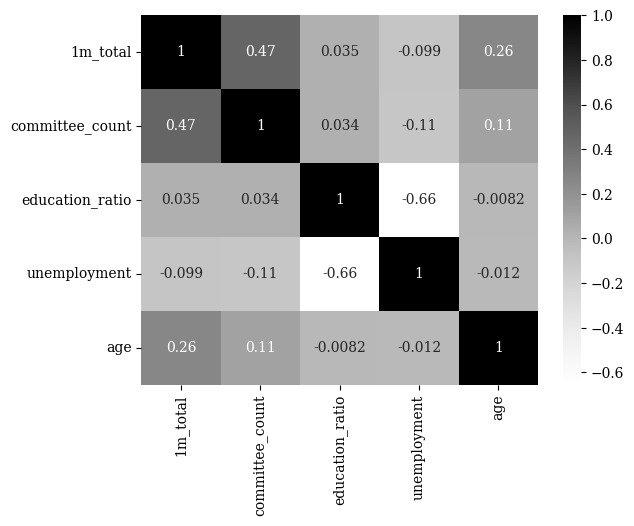

In [ ]:
# look for very white or very black
corr_matrix = X_train[numcolumns].corr()
sns.heatmap(corr_matrix, annot=True, cmap='Greys')
plt.savefig('Numerical Feature Multi-collinearity.png')
plt.show()

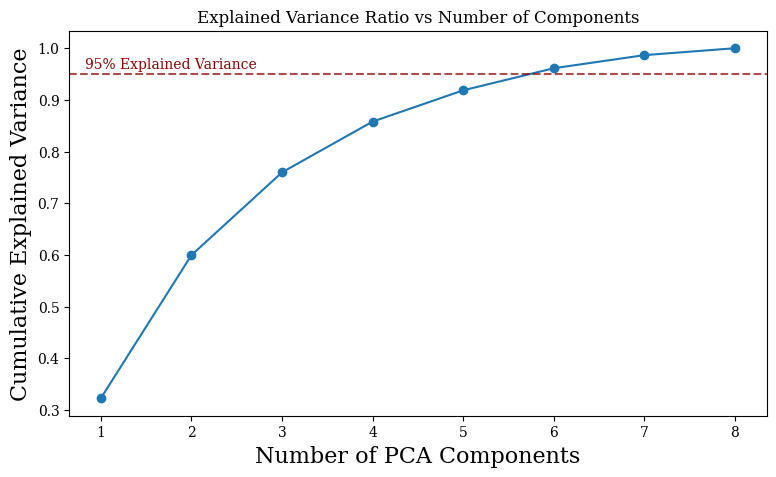

In [ ]:
# use PCA if needed (i did) - Number of Committes and Contributions Received (.47) & Unemployment and Education (-.66). Their dependence needed to be removed.
pca = PCA()
pca.fit(X_train)

plt.subplots(figsize=(9, 5))
# calculate cumulative explained variance
components = pca.components_
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Plot cumulative explained variance
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o')
plt.xlabel('Number of PCA Components', fontsize=16)
plt.ylabel('Cumulative Explained Variance', fontsize=16)

# add red line
plt.axhline(.95, linestyle='--', color='darkred', alpha=0.7)
plt.text(.82, .96, '95% Explained Variance', color='darkred')#, ha='left', va='bottom')

plt.title('Explained Variance Ratio vs Number of Components')
title = 'Explained Variance Ratio vs Number of Components'
plt.savefig(f'{title}.png')

# Show plot
plt.show()

In [ ]:
# select based on the grapgh above. 6 captures around 95% of the varience
# Make sure to use the same '# components' for the test that you chose for the train
n_components = 6
pca = PCA(n_components=n_components)

# fit PCA on the scaled train data
pca.fit(X_train)
X_train_pca = pca.transform(X_train)

# fit PCA on the scaled test data
pca.fit(X_test)
X_test_pca = pca.transform(X_test)

## Now the data is scaled, unbiased, and independent. The scaled data will assist the distance based models like SVM. I scaled the test data using the mean and standard deviation of the train data to ensure no information leaks from the 2020 election into our train dataframe (no bias). I perfromed PCA to remove the linear dependence of the features.


# Modeling

## Create four models to compare with the models with tuned hyperparemtrs. The simple models will be prefered if the performance is close.

In [ ]:
classifiers = {
    'MLP': MLPClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'SVM': SVC()
}

In [ ]:
type(y_train.values)

numpy.ndarray

In [ ]:
from sklearn.metrics import fbeta_score

# Train and evaluate each classifier
for name, clf in classifiers.items():
    # Create a pipeline with preprocessing and the classifier
    pipe = Pipeline(steps=[('classifier', clf)])
    # Train the model
    pipe.fit(X_train, y_train)
    # Make predictions
    y_pred = pipe.predict(X_test)
    # Evaluate the model using F2 score
    f2 = fbeta_score(y_test, y_pred, beta=2)
    print(f"{name} - Test F2 Score: {f2:.4f}")

MLP - Test F2 Score: 0.8456
Random Forest - Test F2 Score: 0.7778
Gradient Boosting - Test F2 Score: 0.7407
SVM - Test F2 Score: 0.7778


## Use cross validation and gridsearch to find the optimal parameters

In [ ]:
import warnings

# Filter out warnings
warnings.filterwarnings('ignore')
# Define classifiers with their respective hyperparameter grids
classifiers = {
  'MLP': (MLPClassifier(),
      {'classifier__hidden_layer_sizes': [(1,)],
        'classifier__activation': ['relu', 'logistic'],
        'classifier__solver': ['adam', 'lbfgs'],
        'classifier__alpha': [0.003, .001, .03]}),

    'Random Forest': (RandomForestClassifier(),
                      {'classifier__n_estimators': [20, 35, 60],
                       'classifier__max_depth': [5, 7, 9]}),

    'Gradient Boosting': (GradientBoostingClassifier(),
                          {'classifier__n_estimators': [50, 150, 400],
                           'classifier__learning_rate': [.001, 0.01, 0.02],
                           'classifier__max_depth': [4]}),

    'SVM': (SVC(),
            {'classifier__C': [.1, 1, 5, 7, 10],
             'classifier__kernel': ['rbf']})
}

# Perform grid search for each classifier
for name, (clf, param_grid) in classifiers.items():
    # Create a pipeline with preprocessing and the classifier
    pipe = Pipeline(steps=[
                           ('classifier', clf)])

    # Perform grid search
    grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='f1_micro')
    grid_search.fit(X_train, y_train)

    # Print best parameters and score
    print(f"Best parameters for {name}: {grid_search.best_params_}")
    #print(f"Best cross-validation score for {name}: {grid_search.best_score_:.4f}")

    # Evaluate the best model on test set
    test_score = grid_search.score(X_test, y_test)
    print(f"Test f1_score for {name}: {test_score:.4f}")

Best parameters for MLP: {'classifier__activation': 'logistic', 'classifier__alpha': 0.03, 'classifier__hidden_layer_sizes': (1,), 'classifier__solver': 'lbfgs'}
Test f1_score for MLP: 0.8553
Best parameters for Random Forest: {'classifier__max_depth': 5, 'classifier__n_estimators': 60}
Test f1_score for Random Forest: 0.8421
Best parameters for Gradient Boosting: {'classifier__learning_rate': 0.02, 'classifier__max_depth': 4, 'classifier__n_estimators': 400}
Test f1_score for Gradient Boosting: 0.8026
Best parameters for SVM: {'classifier__C': 5, 'classifier__kernel': 'rbf'}
Test f1_score for SVM: 0.8421


## create a pipeline with the final hyperparameters and preprocessing steps

In [ ]:
best_parameters = {
    'MLP': {'activation': 'relu', 'alpha': 0.003, 'hidden_layer_sizes': (1,), 'solver': 'lbfgs'},
    'Random Forest': {'max_depth': 6, 'n_estimators': 60},
    'Gradient Boosting': {'learning_rate': 0.02, 'max_depth': 4, 'n_estimators': 400},
    'SVM': {'C': 5, 'kernel': 'rbf'}
}
from sklearn.metrics import classification_report
# Create pipelines using the best parameters
pipelines = {}
for name, params in best_parameters.items():
    if name == 'MLP':
        clf = MLPClassifier(**params)
    elif name == 'Random Forest':
        clf = RandomForestClassifier(**params)
    elif name == 'Gradient Boosting':
        clf = GradientBoostingClassifier(**params)
    elif name == 'SVM':
        clf = SVC(**params)

    pipelines[name] = make_pipeline(clf)

# Evaluate the pipelines
for name, pipeline in pipelines.items():
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    report = classification_report(y_test, y_pred, target_names=["class_0", "class_1"])  # Adjust target names accordingly

    model_name = f"{name}_model.pkl"
    joblib.dump(pipeline, model_name)
    print(f"Saved {name} model as {model_name}")

    print(f"Evaluation for {name}:")
    print(report)

Saved MLP model as MLP_model.pkl
Evaluation for MLP:
              precision    recall  f1-score   support

     class_0       0.88      0.78      0.83        49
     class_1       0.67      0.81      0.73        27

    accuracy                           0.79        76
   macro avg       0.78      0.80      0.78        76
weighted avg       0.81      0.79      0.79        76

Saved Random Forest model as Random Forest_model.pkl
Evaluation for Random Forest:
              precision    recall  f1-score   support

     class_0       0.90      0.90      0.90        49
     class_1       0.81      0.81      0.81        27

    accuracy                           0.87        76
   macro avg       0.86      0.86      0.86        76
weighted avg       0.87      0.87      0.87        76

Saved Gradient Boosting model as Gradient Boosting_model.pkl
Evaluation for Gradient Boosting:
              precision    recall  f1-score   support

     class_0       0.89      0.80      0.84        49
     c

# Ensemble model

In [ ]:
# load the models into variables to prepare
model_name = "MLP_model.pkl"
mlp = joblib.load(model_name)
model_name = "Random Forest_model.pkl"
rf = joblib.load(model_name)
model_name = "SVM_model.pkl"
svm = joblib.load(model_name)
model_name = "Gradient Boosting_model.pkl"
gb = joblib.load(model_name)

# generate weight combinations
first_element_options = [2, 3, 4]
second_elements_options = [4, 5, 6]
third_elements_options = [3, 4, 5]
fourth_elements_options = [1, 2]
combinations = list(itertools.product(first_element_options, second_elements_options, third_elements_options, fourth_elements_options))
combinations_as_lists = [list(combo) for combo in combinations]

# evaluate each combination
for i, combo in enumerate(combinations_as_lists):
  # set the weights based off the individual  perfromances
  voting_clf = VotingClassifier(
      estimators=[('MLP', mlp), ('Random Forest', rf), ('SVM', svm), ('Gradient Boosting', gb)],
      voting='hard',
      weights=combo
  )

  # Fit the voting classifier
  voting_clf.fit(X_train, y_train)

  # Evaluate the voting classifier
  y_pred = voting_clf.predict(X_test)
  f1 = f1_score(y_test, y_pred)
  combinations_as_lists[i].append(f1)

# find the best weights. here are the top 10
sorted_indices = sorted(range(len(combinations_as_lists)), key=lambda x: combinations_as_lists[x][4], reverse=True)
for index in sorted_indices[:20]:
    print(combinations_as_lists[index])

[2, 6, 3, 1, 0.8363636363636364]
[2, 6, 5, 2, 0.8275862068965517]
[4, 6, 4, 2, 0.8275862068965517]
[2, 4, 3, 2, 0.8214285714285715]
[2, 5, 3, 2, 0.8214285714285715]
[3, 4, 3, 1, 0.8214285714285715]
[3, 4, 3, 2, 0.8214285714285715]
[4, 4, 4, 1, 0.8214285714285715]
[4, 4, 5, 2, 0.8214285714285715]
[4, 5, 3, 1, 0.8214285714285715]
[4, 5, 4, 2, 0.8214285714285715]
[4, 6, 4, 1, 0.8214285714285715]
[4, 6, 5, 1, 0.8214285714285715]
[3, 4, 5, 2, 0.8135593220338982]
[4, 4, 5, 1, 0.8135593220338982]
[2, 5, 4, 1, 0.8070175438596491]
[2, 5, 4, 2, 0.8070175438596491]
[2, 5, 5, 1, 0.8070175438596491]
[2, 6, 3, 2, 0.8070175438596491]
[2, 6, 4, 1, 0.8070175438596491]


## Create the ensemble model with the optimal weights

In [ ]:
voting_clf = VotingClassifier(
    estimators=[('MLP', mlp), ('Random Forest', rf), ('SVM', svm), ('Gradient Boosting', gb)],
    voting='hard',
    weights=[4, 6, 5, 1]
)

# fit and evaluate
voting_clf.fit(X_train, y_train)
y_pred = voting_clf.predict(X_test)
f1 = f1_score(y_test, y_pred)

# save
model_name = "voting_model.pkl"
joblib.dump(pipeline, model_name)
ensemble = joblib.load(model_name)

# Performance Evaluation

In [ ]:
# create predictions from each model
mlp_pred = mlp.predict(X_test)
rf_pred = rf.predict(X_test)
gb_pred = gb.predict(X_test)
svm_pred = svm.predict(X_test)
ensemble_pred = ensemble.predict(X_test)

# performance evaluation
mlp_precision = precision_score(y_test, mlp_pred)
mlp_recall = recall_score(y_test, mlp_pred)
mlp_f1 = f1_score(y_test, mlp_pred)

rf_precision = precision_score(y_test, rf_pred)
rf_recall = recall_score(y_test, rf_pred)
rf_f1 = f1_score(y_test, rf_pred)

gb_precision = precision_score(y_test, gb_pred)
gb_recall = recall_score(y_test, gb_pred)
gb_f1 = f1_score(y_test, gb_pred)

svm_precision = precision_score(y_test, svm_pred)
svm_recall = recall_score(y_test, svm_pred)
svm_f1 = f1_score(y_test, svm_pred)

ensemble_precision = precision_score(y_test, ensemble_pred)
ensemble_recall = recall_score(y_test, ensemble_pred)
ensemble_f1 = f1_score(y_test, ensemble_pred)

# Creating a DataFrame
data = {
    'Model': ['MLP', 'Random Forest', 'Gradient Boosting', 'SVM', 'Ensemble'],
    'Precision': [mlp_precision, rf_precision, gb_precision, svm_precision, ensemble_precision],
    'Recall': [mlp_recall, rf_recall, gb_recall, svm_recall, ensemble_recall],
    'F1-Score': [mlp_f1, rf_f1, gb_f1, svm_f1, ensemble_f1]
}

performance_metrics = pd.DataFrame(data)
performance_metrics.to_excel('model_evaluation.xlsx')

In [ ]:
performance_metrics

,Model,Precision,Recall,F1-Score
0,MLP,0.666667,0.814815,0.733333
1,Random Forest,0.814815,0.814815,0.814815
2,Gradient Boosting,0.687500,0.814815,0.745763
3,SVM,0.741935,0.851852,0.793103
4,Ensemble,0.741935,0.851852,0.793103


In [ ]:
performance_metrics['Model'] = performance_metrics['Model'].replace('MLP', 'Neural Network')
performance_metrics['Model'] = performance_metrics['Model'].replace('SVM', 'Support Vector Machine')
performance_metrics['Model'] = performance_metrics['Model'].replace('Ensemble', 'Weighted Ensemble')

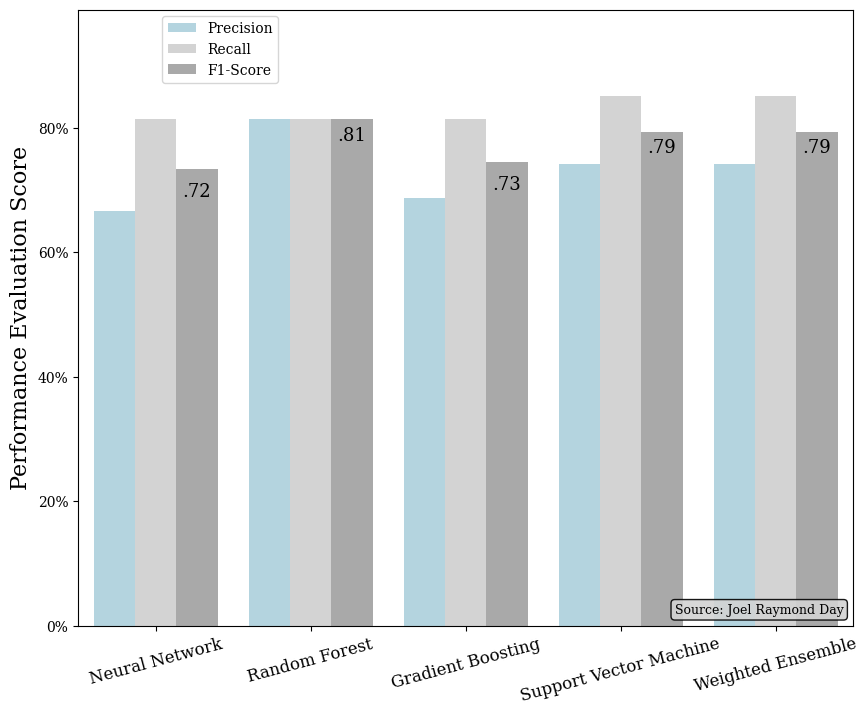

In [ ]:
# new dataframe for visual
dfm = pd.melt(performance_metrics, id_vars="Model", var_name="metric", value_name="score")
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(dfm, x="Model", y="score", hue="metric", palette=['lightblue','lightgray', 'darkgray'])

# rotate x-axis labels
ax.set_xticklabels(ax.get_xticklabels())


# find the x-coordinate for the "Ensemble" category and the rightmost hue position
ensemble_index = dfm['Model'].unique().tolist().index('Weighted Ensemble')
num_hues = dfm['metric'].nunique()
x_coord = ensemble_index + (num_hues - 1) * 0.13  # Adjust the x coordinate to the rightmost hue

# plot the marker
ax.text(.175, .69, '.72', color='black', fontsize=13)#, ha='left', va='bottom')
ax.text(1.175, .78, '.81', color='black', fontsize=13)#, ha='left', va='bottom')
ax.text(2.175, .70, '.73', color='black', fontsize=13)#, ha='left', va='bottom')
ax.text(3.175, .76, '.79', color='black', fontsize=13)#, ha='left', va='bottom')
ax.text(4.175, .76, '.79', color='black', fontsize=13)#, ha='left', va='bottom')


# set labels and legend
title = "Precision, Recall, & F1-Score of 5 Model's Predictions for the 2020 Federal General Senate Elections"
# plt.title(title)
plt.ylabel('Performance Evaluation Score', fontsize=16)
plt.xlabel('')
ax.legend(bbox_to_anchor=(0.1, .87))
ax.set_ylim(bottom=0, top =.99)

from matplotlib.ticker import PercentFormatter

ax.yaxis.set_major_formatter(PercentFormatter(1))

# rotate x-axis labels
plt.xticks(rotation=15, fontsize=12)

# text box
props = dict(boxstyle='round', facecolor='lightgrey', alpha=0.9)
textstr = 'Source: Joel Raymond Day'
ax.text(.77,.02, textstr, transform=ax.transAxes, fontsize=9, bbox=props)

plt.savefig(f'{title}.png')
plt.show()